# Tutorial 1: Background and data preparation

### Outline

* Imports
* Brief discussion of xarray, intake, and zarr
* Brief discussion of ERA5, SRTM, and CMIP6 + downscaling
* Introduction to `torchdata.datapipes`
* Walk through of data processing steps
  * Subsetting to a region
  * Scaling/normalizing the data
  * Conversion between spatio-temporal dataset and ML-ready samples
  * Data splitting for train-valid-test splits
* Demonstration of the total pipeline and export to library code for next steps

#### TODO
 * Add a collection of links for packages being used

In [1]:
!pip install -q zarr torchdata zen3geo dask[distributed] intake xarray fsspec aiohttp regionmask --upgrade
!pip install -q git+https://github.com/carbonplan/cmip6-downscaling.git@1.0
!pip install -q git+https://github.com/xarray-contrib/xbatcher.git@463546e7739e68b10f1ae456fb910a1628de1e5c
!pip install -q jupyterlab-vim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
msal-extensions 0.3.0 requires portalocker~=1.0; platform_system != "Windows", but you have portalocker 2.7.0 which is incompatible.
azure-cli-telemetry 1.0.2 requires applicationinsights<0.11.8,>=0.11.1, but you have applicationinsights 0.11.9 which is incompatible.
azure-cli-telemetry 1.0.2 requires portalocker==1.2.1, but you have portalocker 2.7.0 which is incompatible.
azure-cli-core 2.0.61 requires knack>=0.5.3, but you have knack 0.5.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.5.1 requires portalocker>=2.0.0, but you have portalocker 1.7.1 which is incompatible.
azure-cli-telemetry 1.0.2 requires applicationinsights<0.11.8,>=0.11.1, but you h

In [2]:
import os
import torch
import intake
import regionmask
import xbatcher
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import zen3geo

from tqdm.autonotebook import tqdm
from functools import partial
from dask.distributed import Client, LocalCluster
from torchdata.datapipes.iter import IterDataPipe
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300

# Opening the data

TODO: Gonna need to clean this up and add some exposition...

In [4]:
def merge_data():
    era5_daily_cat = intake.open_esm_datastore(
        'https://cpdataeuwest.blob.core.windows.net/cp-cmip/training/ERA5-daily-azure.json'
    )
    met_files = sorted(list(era5_daily_cat.search(cf_variable_name='tasmax').df['zstore']))
    years = np.arange(1985, 2015)
    swe_files = [f'https://esiptutorial.blob.core.windows.net/eraswe/era5_raw_swe/era5_raw_swe_{year}.zarr'
             for year in years]
    swe_ds = xr.open_mfdataset(swe_files, engine='zarr')
    daily_swe = swe_ds.resample(time='1D').mean().rename({'latitude': 'lat', 'longitude': 'lon'})
    met_ds = xr.open_mfdataset(met_files,  engine='zarr')#.sel(time=swe_data['time'])
    met_ds = met_ds.sel(time=slice(daily_swe['time'].min(), daily_swe['time'].max()))
    met_ds['swe'] = daily_swe['sd']
    mask = xr.open_dataset('https://esiptutorial.blob.core.windows.net/eraswe/mask_10k_household.zarr', engine='zarr')
    terrain = xr.open_dataset('https://esiptutorial.blob.core.windows.net/eraswe/processed_slope_aspect_elevation.zarr', engine='zarr')
    met_ds['mask'] = mask['sd'].rename({'latitude': 'lat', 'longitude': 'lon'})
    met_ds = xr.merge([met_ds, terrain])
    met_ds['mask'] = np.logical_and(~np.isnan(met_ds['elevation']), met_ds['mask']>0 ).astype(int)
    return met_ds

In [5]:
ds = merge_data()
ds

<xarray.Dataset>
Dimensions:        (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat            (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon            (lon) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time           (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Data variables: (12/19)
    pr             (time, lat, lon) float64 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    ps             (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    psl            (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    rsds           (time, lat, lon) float64 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    tas            (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    tasmax         (time, lat, lon) float32 dask.array<chunksize=(365, 150, 150), meta=np.ndarray>
    ...             ...
    swe            (time, lat, lon) float32 dask.array<chunksize=(46, 91, 180), meta=np.ndarray>
    mask           (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    aspect_cosine  (lat, lon) float64 ...
    aspect_sine    (lat, lon) float64 ...
    elevation      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    slope          (lat, lon) float64 ...
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

# Introduction to `torchdata.datapipes`

Before we dive into how we can process this data, let's take a quick side diversion into the `torchdata` package which  
is designed to help with the creation and management of PyTorch datasets. Particularly, we'll use the `datapipes`that provides a set of tools for efficiently loading and transforming data. The key benefit of datapipe is its ability to process data in a streaming fashion, which can significantly reduce the memory usage and processing time of the data loading pipeline.

In [6]:
class RandomNumbersPipe(IterDataPipe):
    
    def __init__(self, sample_shape, number_samples):
        super().__init__()
        self.sample_shape = sample_shape
        self.number_samples = number_samples
        
    def __iter__(self):
        for _ in range(self.number_samples):
            yield torch.randn(self.sample_shape)

In [7]:

randoms = RandomNumbersPipe(sample_shape=(5,2,), number_samples=3)
for sample in randoms:
    print(f'Shape: {sample.shape}, Mean: {torch.mean(sample)}')

Shape: torch.Size([5, 2]), Mean: -0.003410565899685025
Shape: torch.Size([5, 2]), Mean: 0.21885132789611816
Shape: torch.Size([5, 2]), Mean: 0.17591139674186707


The datapipe approach makes it easy to apply transformation functions that can be used to preprocess data as it is loaded. These functions can be chained together to form a pipeline, allowing for complex data transformations to be performed with ease. We'll make use of this to go from the raw, gridded datasets to something that is usable by our model that we'll define in the next tutorial notebook. For now, let's suppose that we simply want to transpose the numbers that come out of the `RandomNumbersPipe` that we used earlier. This is easy enough to write as a simple function, which we call `transpose` below:

In [8]:
def transpose(x):
    return x.T

With this in hand, we can simply call the `map` method on the `randoms` pipe, which produces a new datapipe that can be iterated over. This can easily be seen below:

In [9]:
randoms = RandomNumbersPipe(sample_shape=(5,2,), number_samples=3)
transposed = randoms.map(transpose)

for sample in transposed:
    print(f'Shape: {sample.shape}, Mean: {torch.mean(sample)}')

Shape: torch.Size([2, 5]), Mean: -0.3979613184928894
Shape: torch.Size([2, 5]), Mean: -0.11254427582025528
Shape: torch.Size([2, 5]), Mean: 0.31409674882888794


# The extract-transform-load (ETL) pipeline

Now that we know how to access the raw data and have a basic strategy for manipulating said data into something that can ostensibly be used for training a recurrent neural network (RNN). Our basic starting point will be to subset the global data down to a region of interest. As mentioned in other parts of the tutorial, we take this approach simply to reduce the computational workload and make it easy to run this example in an end-to-end fashion in a timely manner. To do this we will first implement a new `RegionalSubsetterPipe` class which takes the full dataset and a list of regions from the regions defined in Giorgi and Francisco (2020) and dynamically select only one region at a time. In addition to the benefit of making it easy to run this tutorial on limited time/compute, this actually has another practical benefit for running global analyses - which is that most of the gridcells in the global domain actually are not located in areas that we have flagged for snow modeling via the `mask` variable. This regional subsetting means we will have far fewer samples to filter out at training time, which will lower not only the training time but the amount of data that is ultimately transferred over the wire and processed. This type of approach, where we are using 
publicly provided, large, "analysis-ready" datasets is very useful for reproducibility, accessiblility, proof-of-concept research, and learning materials. For larger projects and mature research programs, it usually will be better to actually process the data similarly to what we do here, but save the intermediate samples out to disk/cloud storage directly and avoid the computation associated with the sampling process.

Anyhow, we can define the `RegionalSubsetterPipe` in a relatively straightforward manner, by taking in the full dataset, a sequence of the regions that are to be processed, and optionally a flag for whether to load an entire region into memory up front. The mechancs for actually selecting the region from the raw dataset is slightly involved, so we will walk through that piece in a bit more detail. First, here's the full class:

In [10]:
class RegionalSubsetterPipe(IterDataPipe):
        
    def __init__(self, ds, selected_regions=None, preload=False):
        super().__init__()
        self.ds = ds
        self.selected_regions = self.to_sequence(selected_regions)
        self.preload = preload
        
    def to_sequence(self, seq):
        if isinstance(seq, str):
            return (seq, )
        return seq

    def __iter__(self):
        if not self.selected_regions:
            yield self.ds
        else:
            for region in self.selected_regions:
                self.selected_ds = select_region(self.ds, region)
                if self.preload:
                    self.selected_ds = self.selected_ds.load()
                yield self.selected_ds
 

If you study the `RegionalSubsetterPipe` code closely, you'll note that it calls the `select_region` function inside of the `__iter__` method. This hasn't been defined or imported yet, so before we can actually use this we'll have to figure out a way to select a single region from a given `xarray` dataset. Luckily, most of the functionality for this has already been developed in the `regionmask` package which we installed in the first cell.

Given that, we can define the function, which takes a dataset and the string name of a particular region from the `regionmask.defined_regions.ar6.land` attribute. You can look at that on your own if you're interested in what it contains, but for now we can just make a plot of all of the regions and their abbreviations so that you can easily select regions of interest. Note, in the given tutorial we will be assuming you are using the `WNA` region, but the code should be relatively straightforward enough to modify for other regions.

<GeoAxesSubplot:>

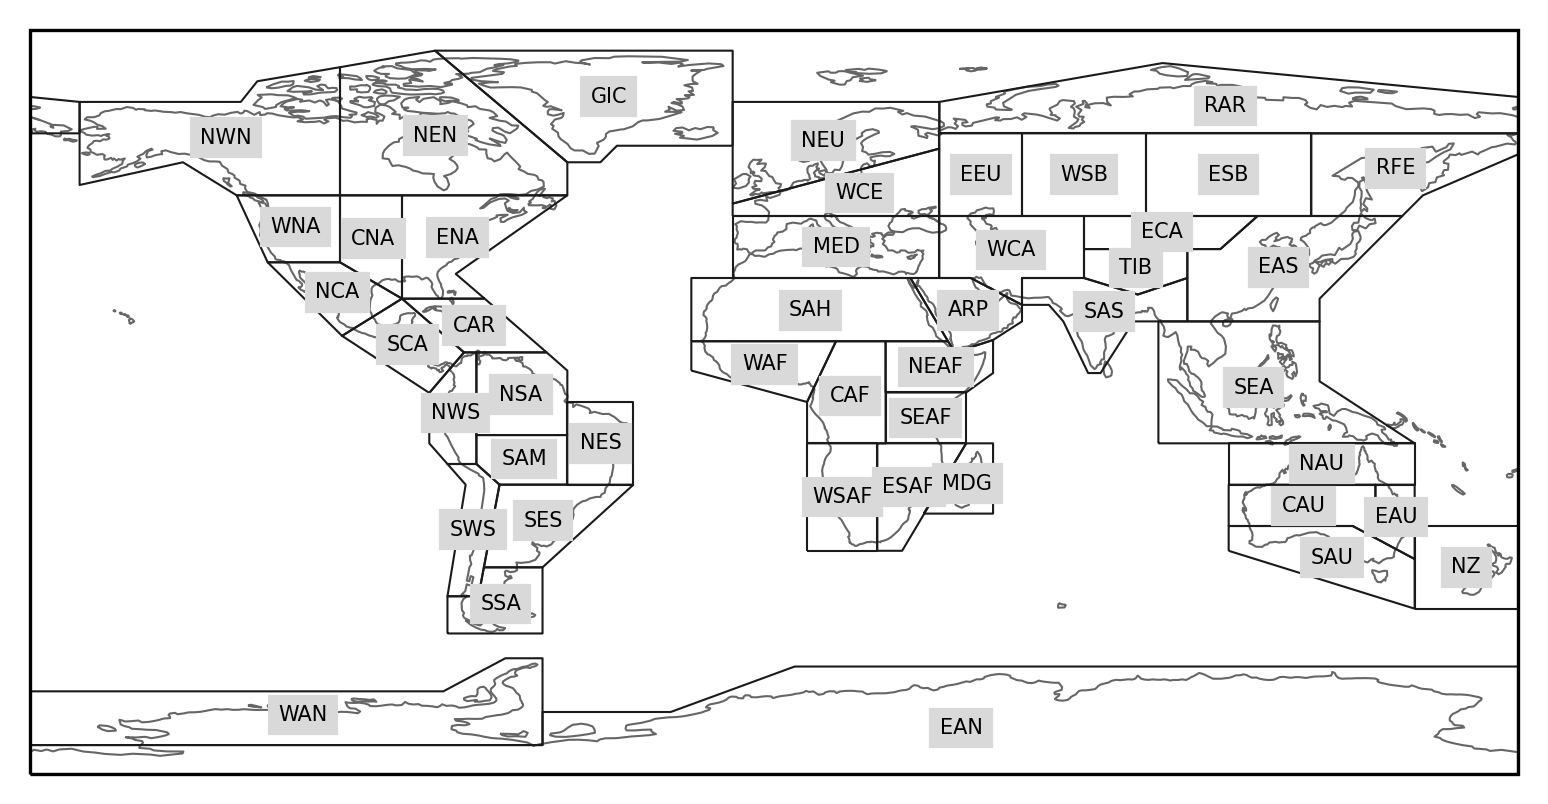

In [11]:
regionmask.defined_regions.ar6.land.plot(
    label='abbrev', 
    text_kws={'fontsize': 5}, 
    line_kws={'linewidth':0.5}
)

Getting back to the task at hand, we just need a function which takes a dataset and a region as a string and then subsets it to the given region. This can be done with `regionmask`'s built in functionality for masking. Given this we just have to find the regions which match the given mask, and then subset them. This is handled below, but we recommend you play with the steps individually if you want to learn how they work in-depth.

In [12]:
def select_region(ds, region): 
    # Get all regions & create mask from lat/lons
    regions = regionmask.defined_regions.ar6.land
    region_id_mask = regions.mask(ds['lon'], ds['lat'])
    # Get unique listing of region names & abbreviations
    reg = np.unique(region_id_mask.values)
    reg = reg[~np.isnan(reg)]
    region_abbrevs = np.array(regions[reg].abbrevs)
    region_names = np.array(regions[reg].names)
    # Create a mask that only contains the region of interest
    selection_mask = 0.0 * region_id_mask.copy()
    region_idx = np.argwhere(region_abbrevs == region)[0][0]
    region_mask = (region_id_mask == reg[region_idx]).astype(int)
    return ds.where(region_mask, drop=True)

As mentioned earlier, one of the benefits of working in the data-pipe framework is we can iteratively develop and test each component of the ETL pipeline in a flexible and modular way that fits really nicely into the Jupyter workflow. To see this in action, let's actually instantiate and test if this behaves as expected!

In [13]:
r = RegionalSubsetterPipe(ds, 'WNA')
for subset in r:
    print(subset.dims)
    print(subset.coords)

Frozen({'time': 10957, 'lat': 65, 'lon': 100})
Coordinates:
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 34.75 34.5 34.25 34.0
  * lon      (lon) float32 230.2 230.5 230.8 231.0 ... 254.2 254.5 254.8 255.0
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31


We can see that this is a subset of the oeverall dataset given the number of latitude and longitude values remaining, and their values tend to match up to what we want, but it's worth making sure things look reasonable before we move on to the rest of the processing pipeline. Here we just show a single map of the data for the first timeset, and can make out most of the major features of the western North America, including some of the coastal oceans which are included before masking things out.

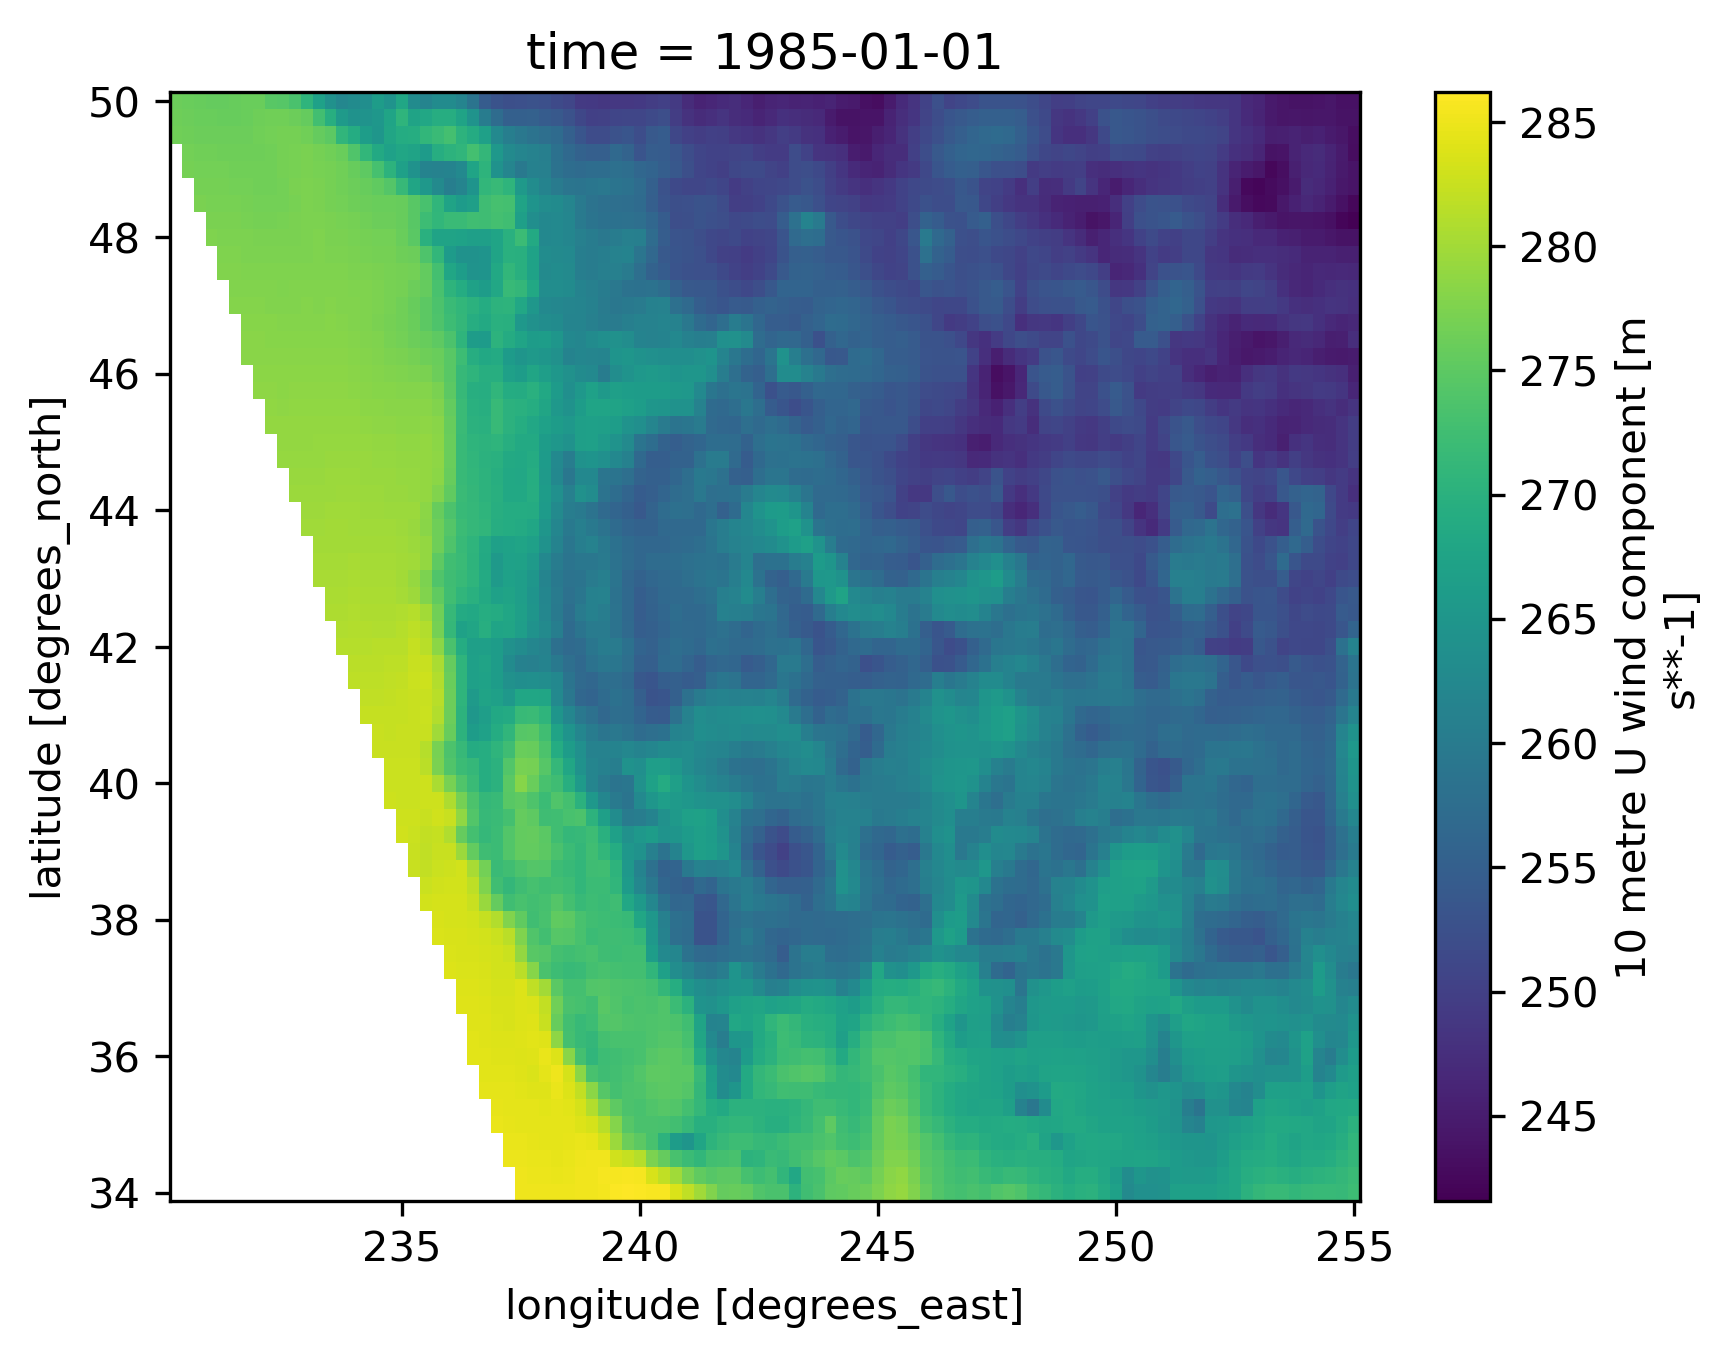

In [14]:
subset['tasmin'].isel(time=0).plot()

So far we have a simple and scalable first step to being able to process this data quickly, since this selection method is lazy and means we can reach this point with almost no actual underlying computation. The next step that is reasonable to ask is: given this as our modeling domain, what does an actual "sample" consist of? Since we are still dealing with a relatively coarse spatial scale we will assume that we can neglect spatial redistribution of snow via wind and other processes. But, because snow accumulation and ablation processes can occur over long time periods we will need to account for time explicitly. That means that we will consider a single sample to be a single grid cell with some time history. We'll get a bit more into how this is actually represented in the model later, but for now we can summarize that we want to select out a single location from the model for a specified period of time. We will use the `xbatcher` python package to actually facilitate this. 

Given we have the `zen3geo` package also installed from the setup cells `xbatcher` and the `torchdata.datapipes` are already interoperable via the `pipe.slice_with_xbatcher` method.  We simply have to define some dimensions to consider a sample and we are good to go. But, before we do that, it's worth taking a moment to discuss samples versus batches. A sample is considered an individual example of the mapping that we want the model to learn. Ideally we could process all samples simultaneously to optimize our model, but as in many other areas where machine learning is common, this is computationally intractable for use. As an alternative to "full batch" processing we use the now standart approach of "mini batch" processing where we group together a small fraction of the total samples available to provide to the model and optimization routine at each update step. This is the reason that learning across large datasets is possible, and we implement this in a simple manner by grouping together nearby gridcells - often referred to as "chunks", "patches", or most commonly in the geospatial community as "chips". 

This is all handles behind the scenes by `xbatcher` simply by specifying the `batch_dims`. The time period that we consider relevant is specified via the `input_dims` argument. We consider this to be 180 days here as a "naive" choice because we have chosen our gridcells of interest to be locations where snow is common, but not present year-round in the ERA5 data. This is a "hyperparameter" that is ripe for further testing.

In [15]:
input_dims={'time': 180}
batch_dims={'lat': 30, 'lon': 30}
input_overlap={'time': 45}

pipe = RegionalSubsetterPipe(ds, ['WNA'])
pipe = pipe.slice_with_xbatcher(
    input_dims=input_dims,
    batch_dims=batch_dims,
    input_overlap=input_overlap,
    preload_batch=False
)
for batch in pipe:
    b = batch
    break
    
b

<xarray.Dataset>
Dimensions:        (time: 180, sample: 900)
Coordinates:
  * time           (time) datetime64[ns] 1985-01-01 1985-01-02 ... 1985-06-29
  * sample         (sample) object MultiIndex
  * lat            (sample) float32 50.0 50.0 50.0 50.0 ... 42.75 42.75 42.75
  * lon            (sample) float32 230.2 230.5 230.8 ... 237.0 237.2 237.5
Data variables: (12/19)
    pr             (sample, time) float64 dask.array<chunksize=(900, 180), meta=np.ndarray>
    ps             (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    psl            (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    rsds           (sample, time) float64 dask.array<chunksize=(900, 180), meta=np.ndarray>
    tas            (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    tasmax         (sample, time) float32 dask.array<chunksize=(900, 180), meta=np.ndarray>
    ...             ...
    swe            (sample, time) float32 dask.array<chunksize=(660, 46), meta=np.ndarray>
    mask           (sample) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    aspect_cosine  (sample) float64 nan nan nan nan ... -0.1117 -0.1347 -0.1164
    aspect_sine    (sample) float64 nan nan nan nan ... 0.02424 0.008986 -0.2774
    elevation      (sample) float64 nan nan nan nan ... 734.1 839.2 1.094e+03
    slope          (sample) float64 nan nan nan nan ... 11.36 10.05 8.716 6.84
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

From this you can see that `xbatcher` has automatically flattened out the latitudes and longitudes into a single `sample` dimension. But, given that our selection from the `regionmask` utility is a square bounding box over the full dataset we still have to consider if all of the data in the `sample` dimension is valid. We will filter this data out with a function that removes any gridcells that do not lie within our predefined mask. This ends up being a simple boolean mask check:

In [16]:
def filter_batch(batch):
    return batch.where(batch['mask']>0, drop=True)

We can then incorporate this into our data processing pipeline simply by calling the `.map` method on our existing pipeline objects with this function as the argument. We will hold off on demonstrating this until we have completed the last two steps of the pipeline, but feel free to experiment with the final code we provide to see how this works in practice.

The next question is, given a batch of data to be fed into a model, do we need to do any "postprocessing" first? Generally it is necessary to scale data to be approximately normalized for deep-learning based models to train effectively. This is no exception in Earth/environmental science applications where inputs/covariates can often span multiple orders of magnitude. We'll use the basic standardization technique where we subtract the mean of the data and divide by the standard deviation for each variable. This sits atop an assumption that our data is somewhat normally distributed, which is certainly not true for all variables but we can get around by making some deliberate choices for scale factors. This would be a ripe area for further exploration, and can result in some nice boosts to both model training speed and end model performance at the end of the day, but can get a bit complex for our purposes here so we leave improvements and tweakes as next steps.

In [17]:
def transform_batch(batch):
    scale_means = xr.Dataset()
    scale_means['mask'] = 0.0
    scale_means['swe'] = 0.0
    scale_means['pr'] = 0.00
    scale_means['tasmax'] = 295.0
    scale_means['tasmin'] = 280.0
    scale_means['elevation'] = 630.0
    scale_means['aspect_cosine'] = 0.0
    
    scale_stds = xr.Dataset()
    scale_stds['mask'] = 1.0
    scale_stds['swe'] = 3.0
    scale_stds['pr'] = 1/100.0
    scale_stds['tasmax'] = 80.0
    scale_stds['tasmin'] = 80.0
    scale_stds['elevation'] = 830.0
    scale_stds['aspect_cosine'] = 1.0
    # Just do a simple standardization
    batch = (batch - scale_means) / scale_stds
    return batch

Nice - we're almost there! Last thing we have to do is actually split the data out into our inputs/outputs. This point is where we have to actually come face-to-face with the data and finally get it into the format that the ML model expects.

At this point we've got a data pipeline that can open the data, slice it up into samples, filter out missing samples, and normalize the data. This is all done as an `xarray.DataSet`, which will first need to be stacked together so all of the variables are part of a single array, and then we will need to make sure that the dimension order matches what our model will expect. For the moment that step will be a leap of faith, but you will see how things pan out in the next portion of the tutorial. Finally, we just need to convert things to a `torch.tensor` so that we can actually take advantage of the PyTorch ecosystem. As a final note, we have implemented things so that if the number of samples is less than some threshold we just skip that batch. This is because our mask was irregular and it's generally not worth running very small samples through our model for training.

In [18]:
def stack_split_convert(
    batch, 
    in_vars, 
    out_vars, 
    in_selectors={},
    out_selectors={},
    min_samples=200
):
    dims = ('sample', 'time', 'variable')
    if len(batch['sample']) > min_samples:
        # Go from a dataset which has multiple variables
        # to a single dataarray, which stacks the variables.
        # Then, transpose them to the desired order for the 
        # model in the next step.
        x = (batch[in_vars]
              .to_array()
              .transpose(*dims))
        y = (batch[out_vars]
              .to_array()
              .transpose(*dims))
        # Convert to `torch.tensor`
        # The call `x.values` converts from xarray to numpy
        # Then following that we convert to the tensor
        # Finally we make sure that we are using 32 bit floats
        x = torch.tensor(x.values).float()
        y = torch.tensor(y.values).float()
    else:
        # Just return an empty tensor so we can skip later
        x, y = torch.tensor([]), torch.tensor([])
    return x, y

Now, note that the `stack_split_convert` function takes many parameters which can be flexibly specified to change how the data comes out. Because pytorch data pipes can only be functions of a single variable, we will need to predefine some of these, and then use a handy tool from the `functools` module called `partial`. 

To explain the `partial` function in a concise manner, let's just go over a simple example. Imagine you have inherited a two argument function aptly named `two_arg_fun` from a colleague:

In [19]:
def two_arg_fun(a, b):
    return a ** b

And further suppose that you know what `b` is for your particular case, and it's a fixed value of 2. Then, it's not terribly difficult to run this once:

In [25]:
fixed_b = 2
x = np.arange(0, 5, 0.05)
y = two_arg_fun(x, b=fixed_b)

But, where `partial` comes in is making it easy to define a new function that not only has a name, but can be passed around to other functions. For example, in our very simple case we can reproduce the prevous behavior with:

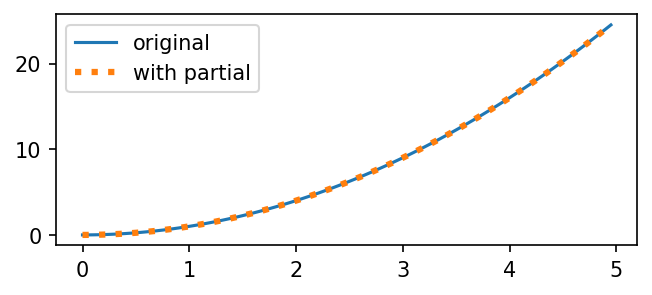

In [21]:
f, ax = plt.subplots(1, 1, dpi=150, figsize=(5,2))
fixed_fun = partial(two_arg_fun, b=fixed_b)
ax.plot(x, y, label='original')
ax.plot(x, fixed_fun(x), label='with partial', linestyle=':', linewidth=3)
plt.legend()

Given that small, practical example let's get back to our final piece of the data pipeline. We just need to be able to inject variables into the `stack_split_convert` function. We can define all of them up front, which acts as a nice "configuration" step as we'll see later. This will define all of the important things for our training workflow like what the inputs and targets/outputs are, sequence lengths, dimensions of our batch sizes, and how much to overlap training samples. With everything configured we can just run it through the `partial` function with relevant keywords and then we are good to put things together.

In [23]:
in_vars = ['pr',  'tasmax',  'tasmin',  'elevation',  'aspect_cosine']
out_vars = ['swe']
output_sequence_length = 1
output_selector = {'time': slice(-output_sequence_length, None)}

In [24]:
convert = partial(
    stack_split_convert, 
    in_vars=in_vars, 
    out_vars=out_vars, 
    out_selectors=output_selector,
)

## Putting it all together

Wow, it's been a bit of work to get here, but that's all of the components for our data processing pipeline. Now we just need to be able to assemble it. We promised that the point of using `torchdata.datapipes` was to simplify things and now you finally get to see that in action! We have a bit more configuration set up just for example.

In [ ]:
regions = ['WNA']
varlist = ['mask'] + in_vars + out_vars
input_sequence_length = 180  
input_dims={'time': input_sequence_length}
batch_dims={'lat': 30, 'lon': 30}
input_overlap={'time': 45}

And, we can now actually chain things together and try it out. This is a crucial step in developing your own data pipelines, so make sure to see how each of the above steps is incorporated into the final pipeline of steps below. You can (and should) verify that the pipeline works before you step through to the next notebook, but that's simple enough.

In [ ]:
# Open the data and subset to region
dp = RegionalSubsetterPipe(ds[varlist], regions)
# Generate chips from the region
dp = dp.slice_with_xbatcher(
    input_dims=input_dims,
    batch_dims=batch_dims,
    preload_batch=False
)
# Filter out any missing data
dp = dp.map(filter_batch)
# Transform/normalize the data
dp = dp.map(transform_batch)
# Reshape and convert it to a torch.tensor
dp = dp.map(convert)

x, y = next(iter(dp))
print('Input batch has shape:  ', x.shape)
print('Target batch has shape: ', y.shape)

## Automating the data pipeline creation

Now that we have a 

In [ ]:
def make_data_pipeline(
    ds, 
    regions, 
    input_vars, 
    output_vars,
    input_sequence_length,
    output_sequence_length,
    batch_dims,
    input_overlap,
):
    # Preamble: just set some stuff up
    output_selector = {'time': slice(-output_sequence_length, None)}
    input_dims={'time': input_sequence_length}
    varlist = ['mask'] + input_vars + output_vars
    convert = partial(
        stack_split_convert, 
        in_vars=input_vars, 
        out_vars=output_vars, 
        out_selectors=output_selector,
        device=DEVICE
    )
    # Chain together the datapipe
    dp = RegionalSubsetterPipe(ds[varlist], selected_regions=regions)
    dp = dp.slice_with_xbatcher(
        input_dims=input_dims,
        batch_dims=batch_dims,
        input_overlap=input_overlap,
        preload_batch=False
    )
    dp = dp.map(filter_batch)
    dp = dp.map(transform_batch)
    dp = dp.map(convert)   
    return dp

In [ ]:
p = make_data_pipeline(
    ds, ['WNA'], in_vars, out_vars,
    input_sequence_length, output_sequence_length,
    batch_dims, input_overlap
)

In [ ]:
next(iter(p))